In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import detectron2
import torch
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
import matplotlib
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['figure.dpi']=100
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from vis_det.model_pool import get_data, get_model
from vis_det.data import query_image,data_preprocessing
from detectron2.utils.visualizer import Visualizer
from vis_det.optimize import layout_optimize, layout_vis_loss

In [4]:
## load data 
coco_val, coco_val_meta = get_data("kitti")

finish registering kitti_semantics_instance_train to DatasetCatalog.


In [5]:
## load model and corresponding arg, cfg and predictor.
model, args, cfg, predictor = get_model("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN")
# model, args, cfg, predictor = get_model("COCO-Detection/retinanet_R_50_FPN")
# model, args, cfg, predictor = get_model("COCO-Detection/faster_rcnn_R_50_FPN")

In [9]:
coco_val[0]

{'file_name': '/home/devenish/Desktop/delight/datasets/kitti_semantics_cs/data_semantics/train/kitti/kitti_000132_10_leftImg8bit.png',
 'image_id': 'kitti_000132_10_leftImg8bit.png',
 'height': 375,
 'width': 1242,
 'annotations': [{'iscrowd': True,
   'category_id': 2,
   'bbox': (498, 174, 644, 196),
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'segmentation': [[519,
     179,
     518,
     180,
     517,
     180,
     516,
     180,
     515,
     181,
     514,
     181,
     513,
     181,
     512,
     181,
     511,
     181,
     510,
     182,
     509,
     182,
     508,
     182,
     507,
     182,
     506,
     182,
     505,
     183,
     504,
     183,
     503,
     183,
     502,
     184,
     501,
     184,
     500,
     184,
     499,
     185,
     498,
     185,
     499,
     185,
     500,
     185,
     501,
     185,
     502,
     185,
     503,
     185,
     504,
     185,
     505,
     184,
     506,
     184,
     507,
     184,
     508,
     184,
 

In [11]:
## load the target image layouts and show.
#target_img = "000000439715"
target_img = coco_val[0]['file_name']
target_image = query_image(target_img, coco_val)
#print(target_image)

/home/devenish/Desktop/delight/datasets/kitti_semantics_cs/data_semantics/train/kitti/kitti_000132_10_leftImg8bit.png


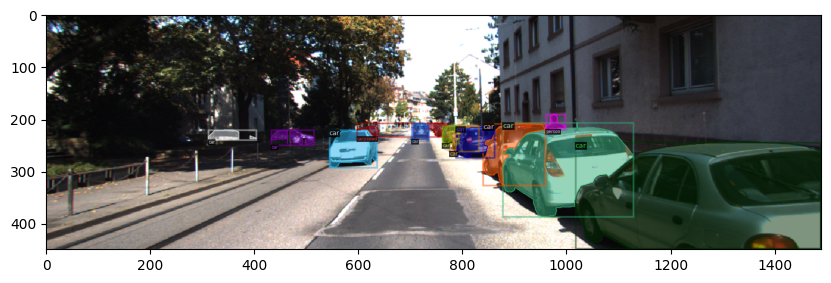

In [12]:
images, gt_instances, mapper_target = data_preprocessing(cfg,target_image,model)
img = cv2.imread(target_image["file_name"])
visualizer = Visualizer(img, metadata=coco_val_meta, scale=1.2)
vis = visualizer.draw_dataset_dict(target_image)
plt.imshow(vis.get_image()[:,:,::-1])

In [13]:
%%time
loss_func = layout_vis_loss(args)
inverter = layout_optimize(args, cfg)
x = inverter.invert(images, gt_instances, model, loss_func)

Into Invert
Mask Invert
Initialization 
iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
CPU times: user 15min 49s, sys: 23.3 s, total: 16min 13s
Wall time: 6min 53s


The GPU memory usage is around 4GB.
CPU times: user 15min 49s, sys: 23.3 s, total: 16min 13s
Wall time: 6min 53s

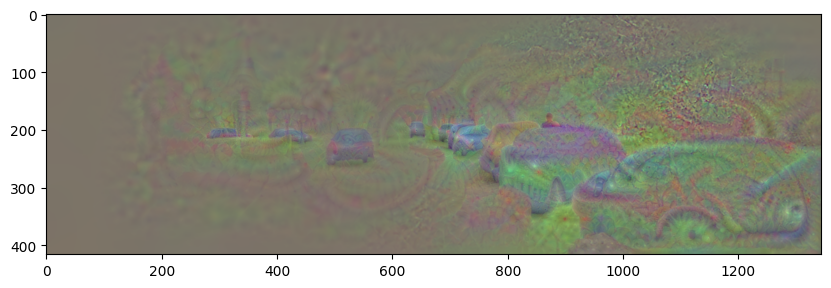

In [14]:
# draw the inverse
inverse_img = inverter.post_processing(x)
plt.imshow(inverse_img[0][:,:,::-1])

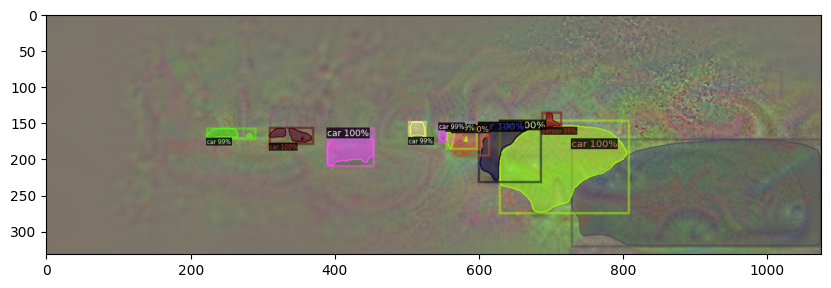

In [15]:
## show the prediction results.
inverse_img = inverse_img[0]
outputs = predictor(inverse_img)
v1 = Visualizer(inverse_img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
v1 = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v1.get_image())